## Imports & Setup

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
import lightgbm as lgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load Dataset

In [2]:
# Load dataset and basic checks
csv_path = 'breast_cancer.csv'
assert os.path.exists(csv_path), 'breast_cancer.csv not found in project root.'

df = pd.read_csv(csv_path)
print('Original shape:', df.shape)
print(df.head())
print(df.info())

# Drop non-informative identifiers if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Encode target: diagnosis (M=1, B=0)
assert 'diagnosis' in df.columns, 'Expected target column "diagnosis" not found.'
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0}).astype(int)

# Handle missing values (median for numeric)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

print('Post-clean shape:', df.shape)
df.head()



Original shape: (569, 32)
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst 

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## Clean (drop ID)

In [6]:
df = df.copy()

# drop id-like column if present
if "id" in df.columns:
    df = df.drop(columns=["id"])

## Encode Target

In [7]:
# encode target: diagnosis (B=0, M=1)
assert "diagnosis" in df.columns, "Target column 'diagnosis' not found."
le = LabelEncoder()
df["diagnosis"] = le.fit_transform(df["diagnosis"])  # B->0, M->1

## Handle Missing

In [8]:
na_before = df.isna().sum()
num_cols = [c for c in df.columns if c != "diagnosis"]
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

print("Missing values before:\n", na_before[na_before > 0])
print("Missing values after:\n", df.isna().sum()[df.isna().sum() > 0])
df.head()

Missing values before:
 Series([], dtype: int64)
Missing values after:
 Series([], dtype: int64)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## Lightweight Feature Engineering (no target leakage)

In [10]:
fe = df.copy()
eps = 1e-9

# shape ratios (robust geometric relations)
if set(["area_mean", "perimeter_mean", "radius_mean"]).issubset(fe.columns):
    fe["area_perimeter_ratio_mean"]  = fe["area_mean"]      / (fe["perimeter_mean"] + eps)
    fe["perimeter_radius_ratio_mean"]= fe["perimeter_mean"] / (fe["radius_mean"] + eps)

if set(["area_worst", "perimeter_worst", "radius_worst"]).issubset(fe.columns):
    fe["area_perimeter_ratio_worst"]   = fe["area_worst"]      / (fe["perimeter_worst"] + eps)
    fe["perimeter_radius_ratio_worst"] = fe["perimeter_worst"] / (fe["radius_worst"] + eps)

# worst/mean stability ratios
pairs = [
    ("radius_worst","radius_mean"),
    ("perimeter_worst","perimeter_mean"),
    ("area_worst","area_mean"),
    ("compactness_worst","compactness_mean"),
    ("concavity_worst","concavity_mean"),
    ("concave points_worst","concave points_mean"),
]
for w, m in pairs:
    if w in fe.columns and m in fe.columns:
        fe[f"{w}_over_{m}"] = fe[w] / (fe[m] + eps)

print("New cols:", [c for c in fe.columns if c not in df.columns])
fe.head()

New cols: ['area_perimeter_ratio_mean', 'perimeter_radius_ratio_mean', 'area_perimeter_ratio_worst', 'perimeter_radius_ratio_worst', 'radius_worst_over_radius_mean', 'perimeter_worst_over_perimeter_mean', 'area_worst_over_area_mean', 'compactness_worst_over_compactness_mean', 'concavity_worst_over_concavity_mean', 'concave points_worst_over_concave points_mean']


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,area_perimeter_ratio_mean,perimeter_radius_ratio_mean,area_perimeter_ratio_worst,perimeter_radius_ratio_worst,radius_worst_over_radius_mean,perimeter_worst_over_perimeter_mean,area_worst_over_area_mean,compactness_worst_over_compactness_mean,concavity_worst_over_concavity_mean,concave points_worst_over_concave points_mean
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,8.151466,6.826014,10.937161,7.273444,1.410784,1.503257,2.016983,2.397695,2.372209,1.804215
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,9.977427,6.460865,12.317380,6.354542,1.214876,1.194883,1.475113,2.372838,2.780207,2.650705
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,9.253846,6.602336,11.206557,6.470089,1.197054,1.173077,1.420615,2.654784,2.281662,1.899922
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,4.976798,6.793345,5.741883,6.631120,1.305604,1.274426,1.470344,3.051427,2.845485,2.447719
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,9.600296,6.658452,10.348226,6.752440,1.110892,1.126573,1.214341,1.543675,2.020202,1.558006


## Visualizations

In [11]:
from sklearn.preprocessing import StandardScaler

feature_cols = [c for c in fe.columns if c != "diagnosis"]
X_feat = fe[feature_cols].copy()

_feature_scaler = StandardScaler()
X_scaled = pd.DataFrame(_feature_scaler.fit_transform(X_feat), columns=feature_cols)

X_feat.shape, X_scaled.shape

((569, 40), (569, 40))

## Correlation Heatmap (features only)

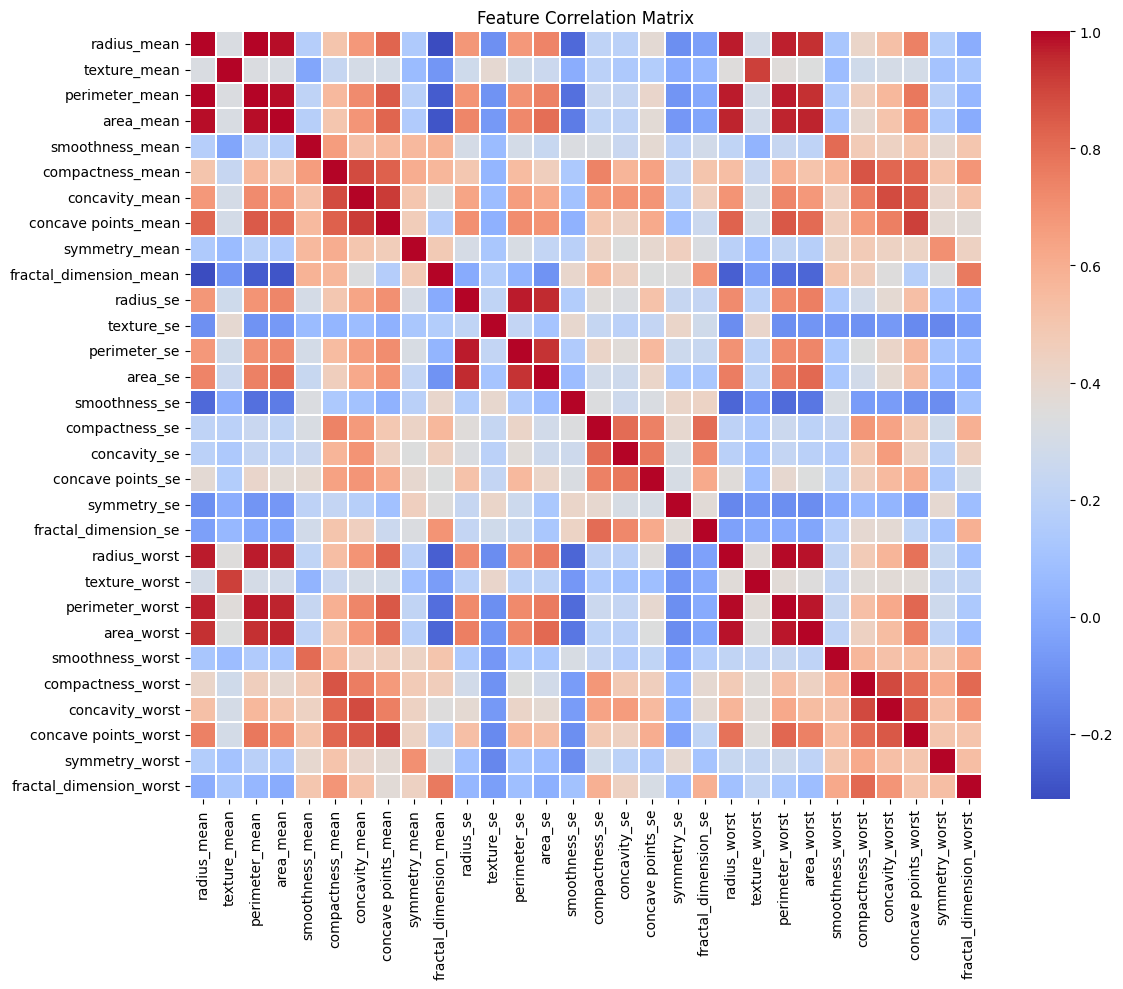

In [12]:
# Correlation matrix heatmap (numeric features only)
plt.figure(figsize=(12, 10))
num_df = df.drop(columns=['diagnosis']).select_dtypes(include=[np.number])
corr = num_df.corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.3)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


## Top Absolute Correlated Pairs (table)

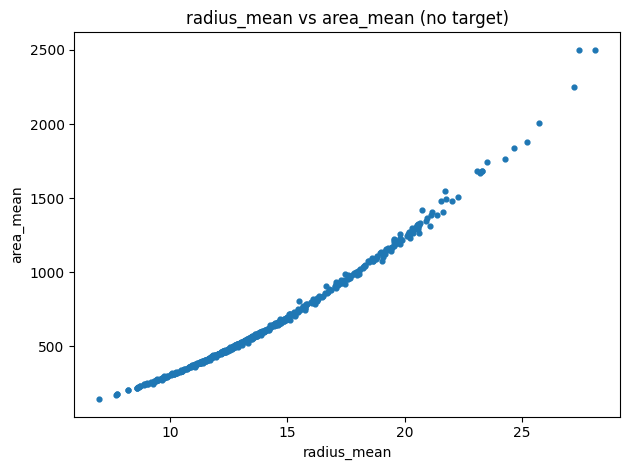

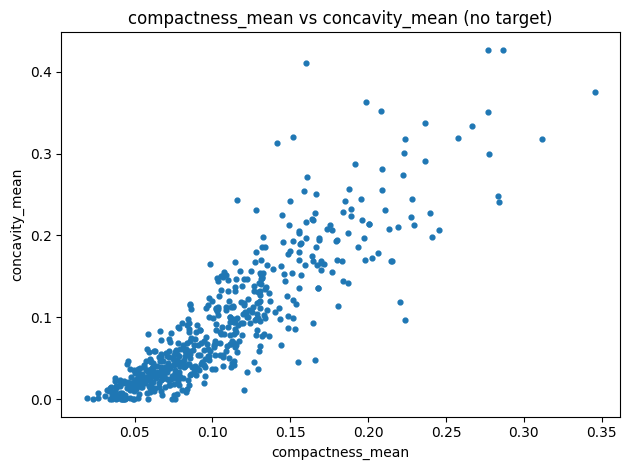

In [13]:
def scatter_two_features(df, f1, f2, use_scaled=False):
    src = X_scaled if use_scaled else df
    plt.figure()
    plt.scatter(src[f1], src[f2], s=12)
    sp = " (scaled)" if use_scaled else ""
    plt.title(f"{f1} vs {f2}{sp} (no target)")
    plt.xlabel(f1); plt.ylabel(f2)
    plt.tight_layout(); plt.show()

# examples — edit freely
scatter_two_features(X_feat, "radius_mean", "area_mean")
scatter_two_features(X_feat, "compactness_mean", "concavity_mean")

## Histograms (first K features, one plot per feature)

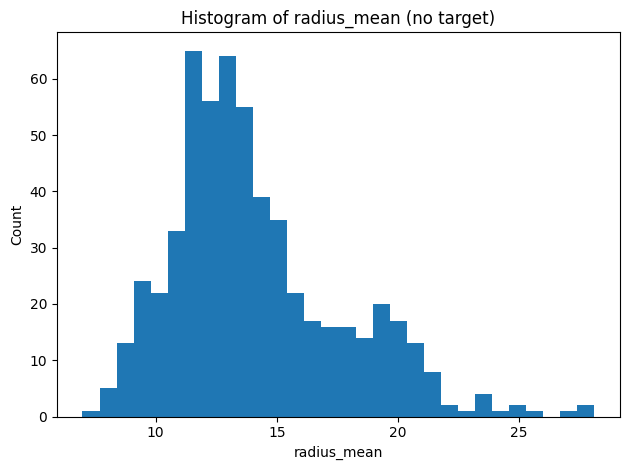

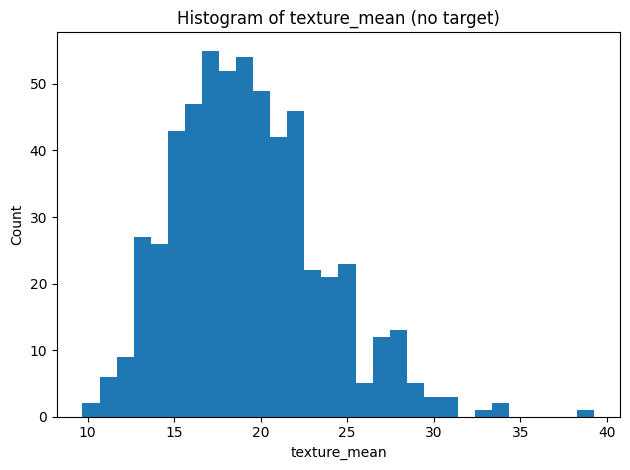

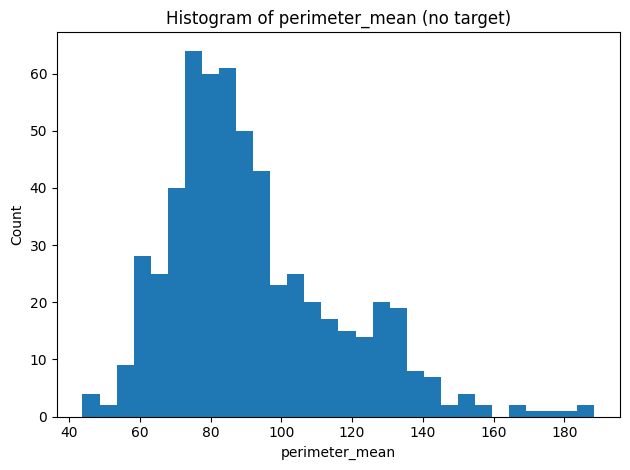

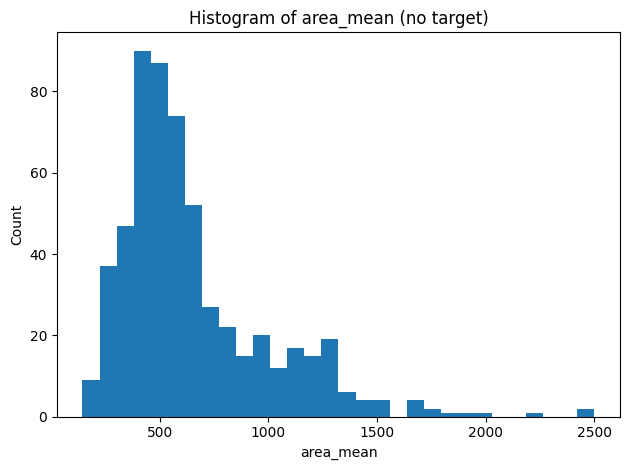

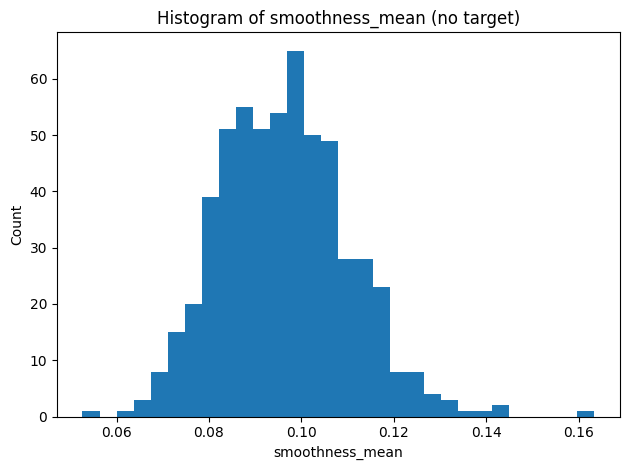

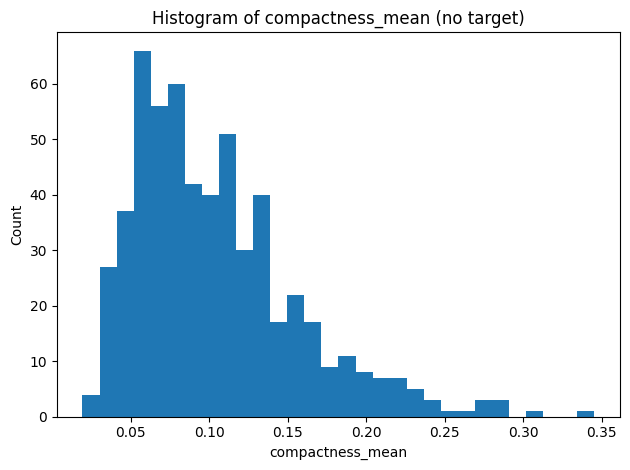

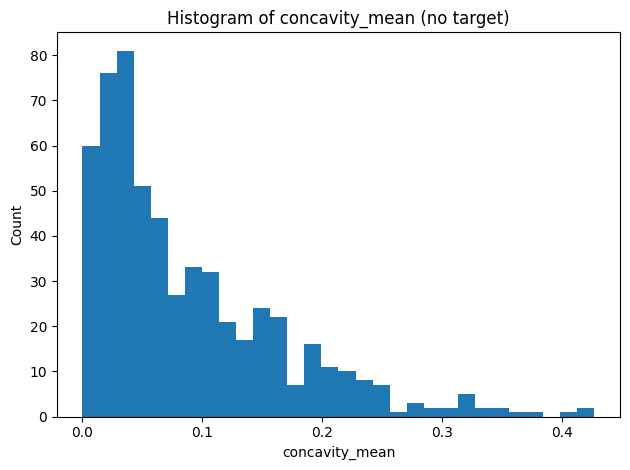

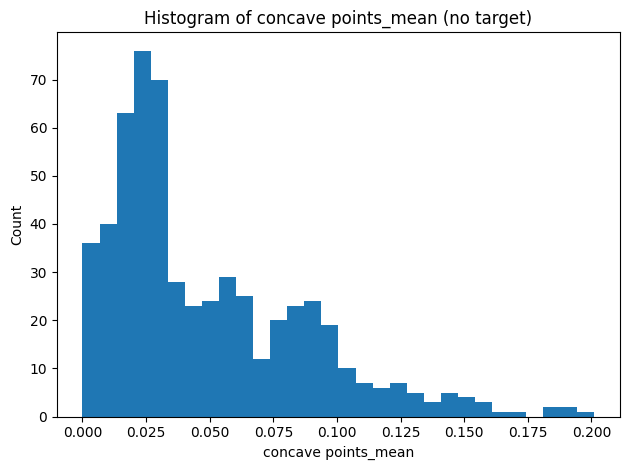

In [14]:
K = 8
for col in feature_cols[:K]:
    plt.figure()
    plt.hist(X_feat[col].dropna(), bins=30)
    plt.title(f"Histogram of {col} (no target)")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

## Boxplots (first K features, one plot per feature)

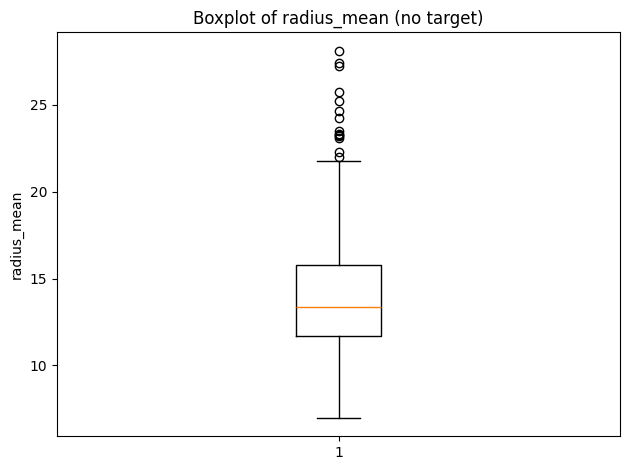

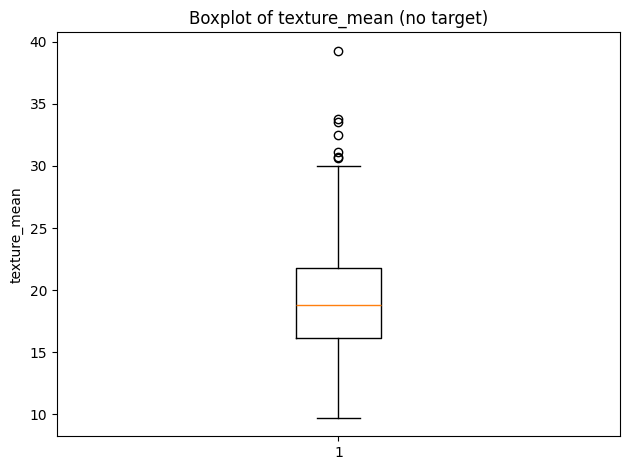

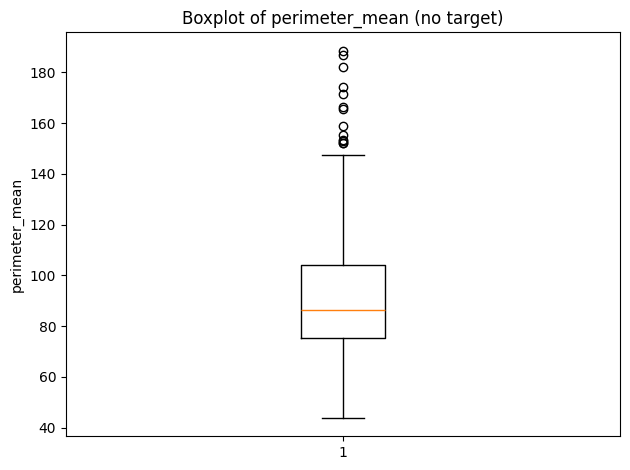

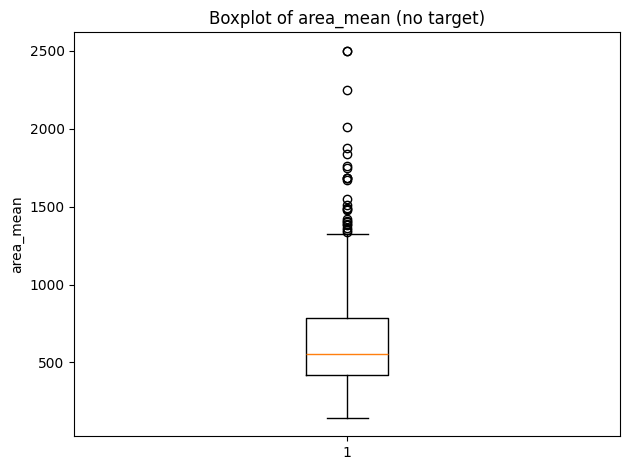

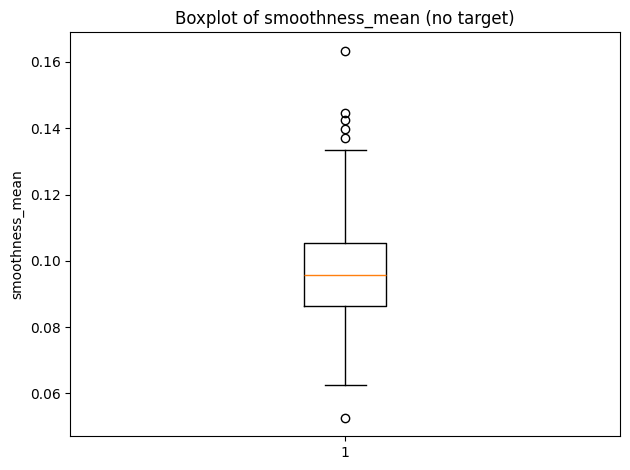

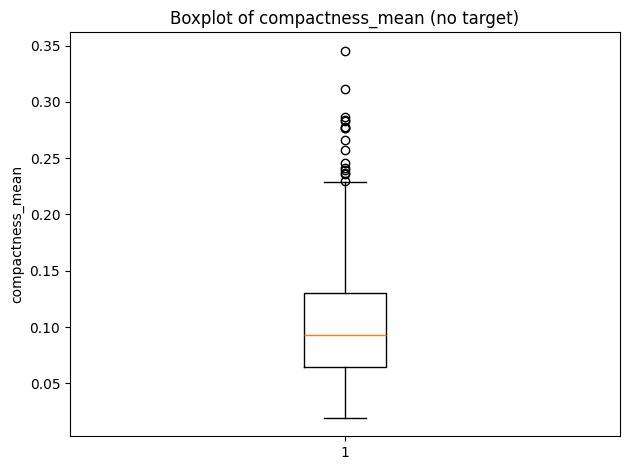

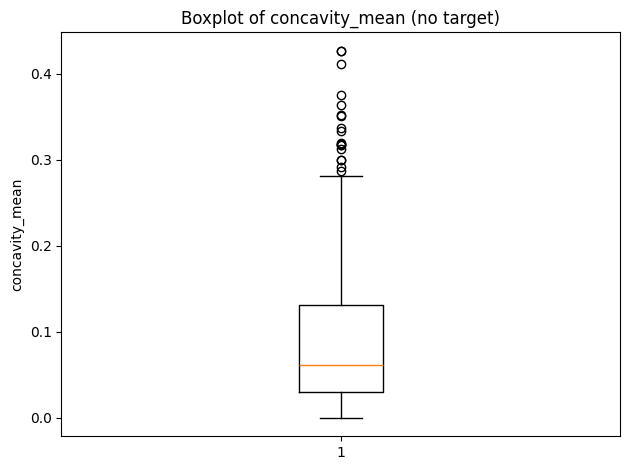

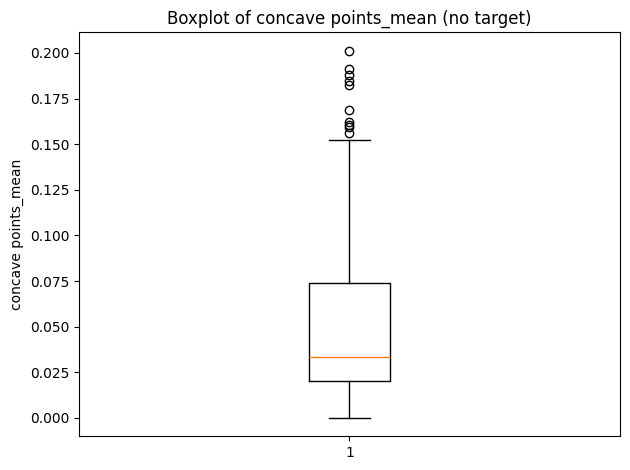

In [15]:
K = 8
for col in feature_cols[:K]:
    plt.figure()
    plt.boxplot(X_feat[col].dropna(), vert=True)
    plt.title(f"Boxplot of {col} (no target)")
    plt.ylabel(col)
    plt.tight_layout(); plt.show()

## PCA (2D) on Features Only

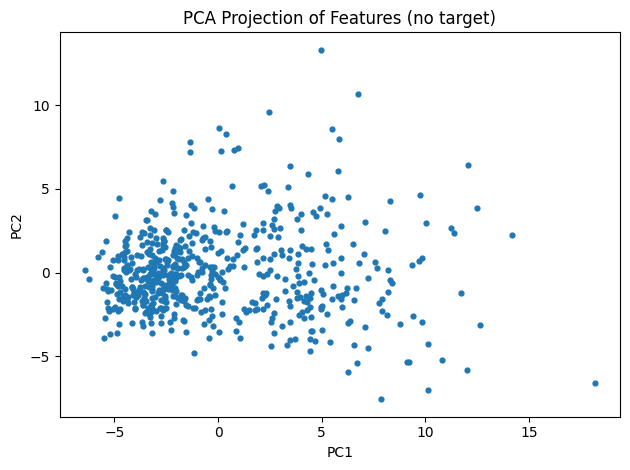

Explained variance ratio: [0.4317044  0.16407327]


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], s=12)
plt.title("PCA Projection of Features (no target)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

## Class Distribution

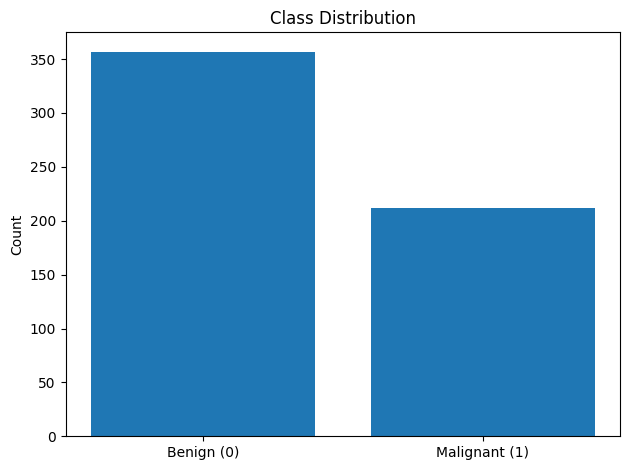

,count
diagnosis,
0,357
1,212


In [17]:
counts = fe["diagnosis"].value_counts().sort_index()
plt.figure()
plt.bar(["Benign (0)", "Malignant (1)"], counts.values)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.tight_layout(); plt.show()
counts.to_frame("count")

## Scatter Colored by Class (two features)

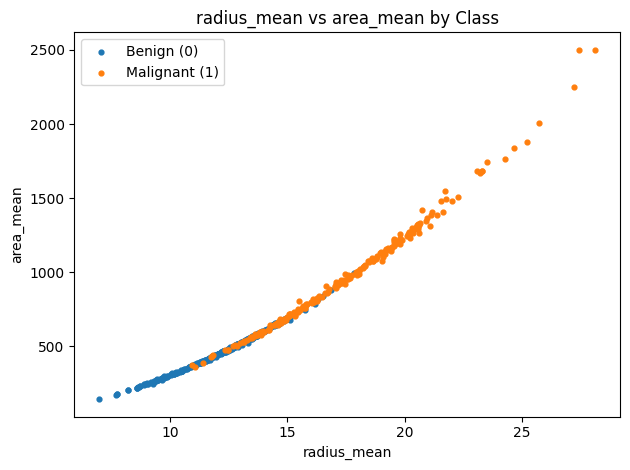

In [18]:
f1, f2 = "radius_mean", "area_mean"
x0 = fe.loc[fe.diagnosis==0, f1].values
y0 = fe.loc[fe.diagnosis==0, f2].values
x1 = fe.loc[fe.diagnosis==1, f1].values
y1 = fe.loc[fe.diagnosis==1, f2].values

plt.figure()
plt.scatter(x0, y0, s=12, label="Benign (0)")
plt.scatter(x1, y1, s=12, label="Malignant (1)")
plt.title(f"{f1} vs {f2} by Class")
plt.xlabel(f1); plt.ylabel(f2)
plt.legend()
plt.tight_layout(); plt.show()

## Histograms by Class (one feature, separate plots)

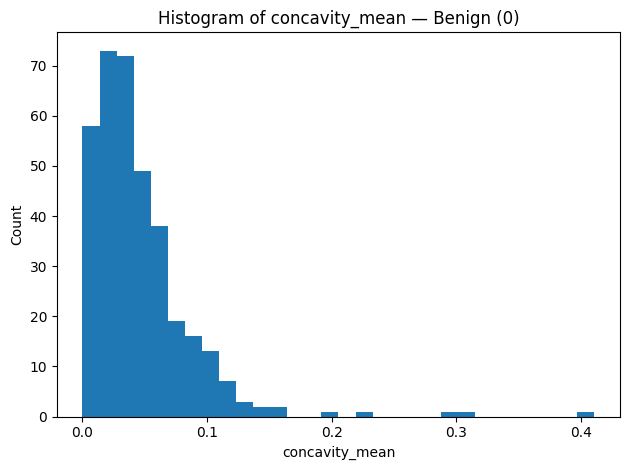

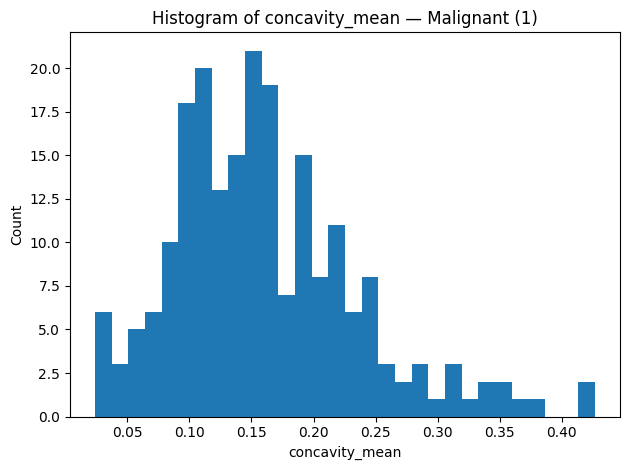

In [19]:
col = "concavity_mean"

# Benign
plt.figure()
plt.hist(fe.loc[fe.diagnosis==0, col].dropna(), bins=30)
plt.title(f"Histogram of {col} — Benign (0)")
plt.xlabel(col); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Malignant
plt.figure()
plt.hist(fe.loc[fe.diagnosis==1, col].dropna(), bins=30)
plt.title(f"Histogram of {col} — Malignant (1)")
plt.xlabel(col); plt.ylabel("Count")
plt.tight_layout(); plt.show()

## Side-by-Side Boxplots by Class (one feature)

C:\Users\User\AppData\Local\Temp\ipykernel_15088\3176761367.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], vert=True, labels=["Benign (0)", "Malignant (1)"])


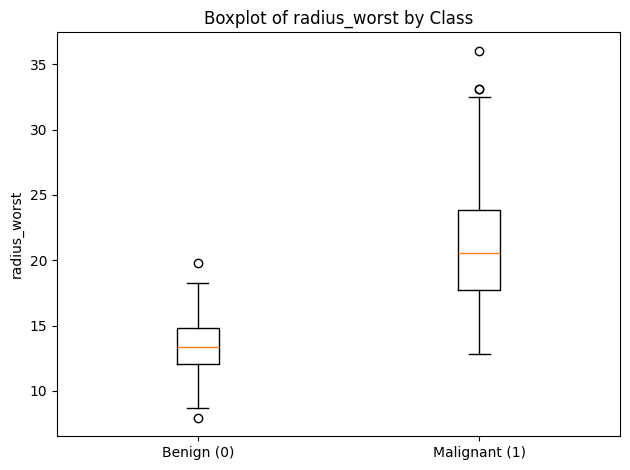

In [20]:
col = "radius_worst"
data0 = fe.loc[fe.diagnosis==0, col].dropna().values
data1 = fe.loc[fe.diagnosis==1, col].dropna().values

plt.figure()
plt.boxplot([data0, data1], vert=True, labels=["Benign (0)", "Malignant (1)"])
plt.title(f"Boxplot of {col} by Class")
plt.ylabel(col)
plt.tight_layout(); plt.show()

## PCA (2D) Colored by Class

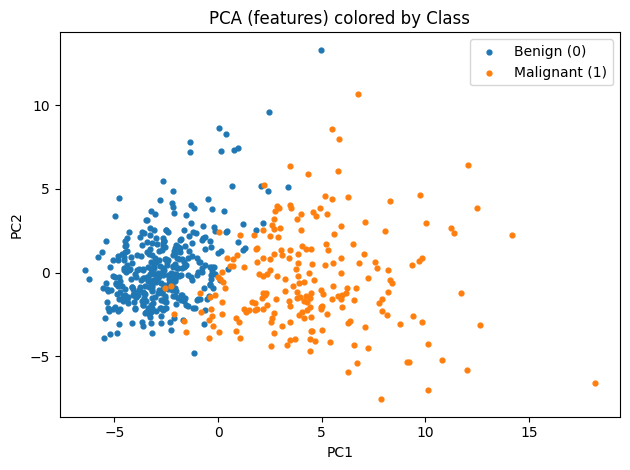

Explained variance ratio: [0.4317044  0.16407327]


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_only = fe.drop(columns=["diagnosis"])
X_only_scaled = StandardScaler().fit_transform(X_only)

pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
Z2 = pca2.fit_transform(X_only_scaled)

idx0 = fe["diagnosis"].values == 0
idx1 = ~idx0

plt.figure()
plt.scatter(Z2[idx0, 0], Z2[idx0, 1], s=12, label="Benign (0)")
plt.scatter(Z2[idx1, 0], Z2[idx1, 1], s=12, label="Malignant (1)")
plt.title("PCA (features) colored by Class")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout(); plt.show()

print("Explained variance ratio:", pca2.explained_variance_ratio_)

# Train/Test, Balance, Scale, Models, Ensemble

## Split (Stratified)

In [22]:
# Train/test split, scaling, and SMOTE on training set
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train class distribution (after SMOTE):', np.bincount(y_train_bal))


Train shape: (455, 30) Test shape: (114, 30)
Train class distribution (after SMOTE): [285 285]


## Handle Imbalance (SMOTE on Train Only)

In [23]:
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After  SMOTE:", y_train_res.value_counts().to_dict())

Before SMOTE: {0: 285, 1: 170}
After  SMOTE: {1: 285, 0: 285}


## Scale Features

In [24]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## Decision Tree


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        72
           1       0.90      0.90      0.90        42

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



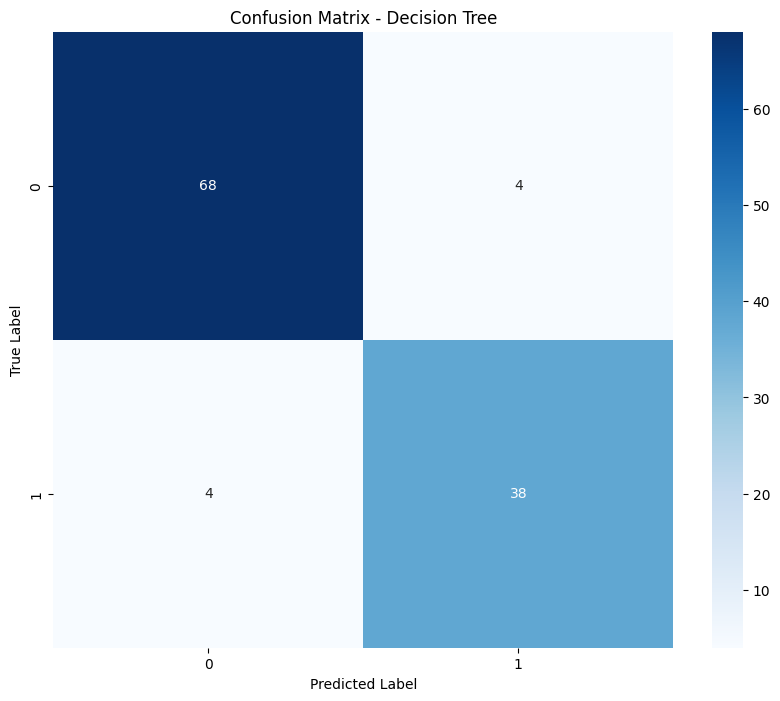

In [25]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Print model performance metrics
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Create confusion matrix
plt.figure(figsize=(10, 8))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Random Forest



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



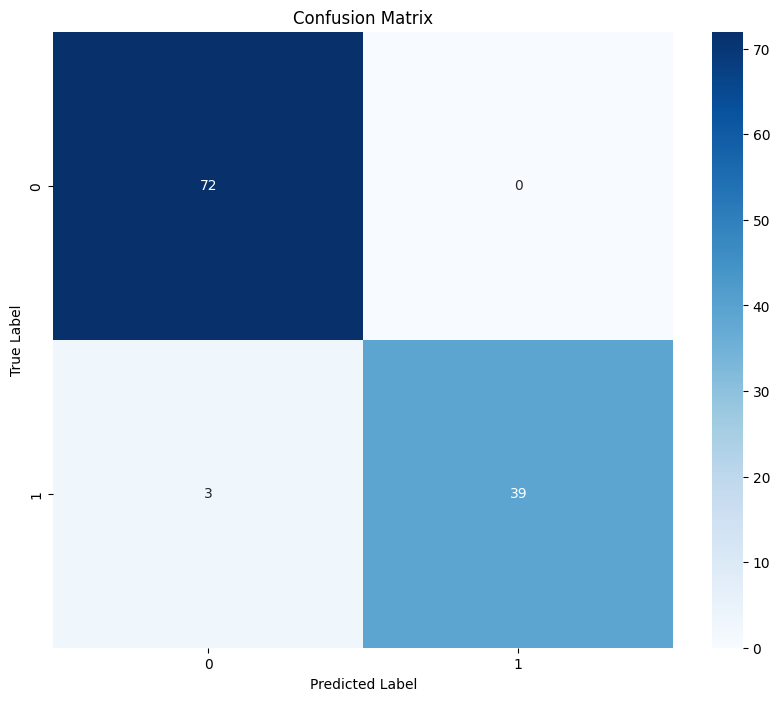

In [26]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=44)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print model performance metrics
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Logistic Regression

d:\ML_ASIF_OWN PROJCET\Breast_Cancer_Classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



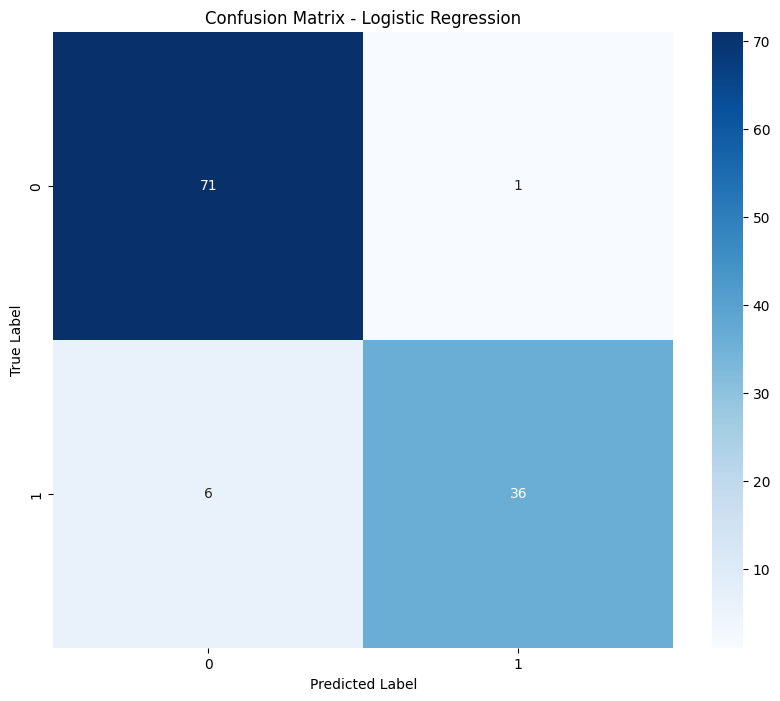

In [27]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Print model performance metrics
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Create confusion matrix
plt.figure(figsize=(10, 8))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## KNN Classifier


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        72
           1       0.97      0.79      0.87        42

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114



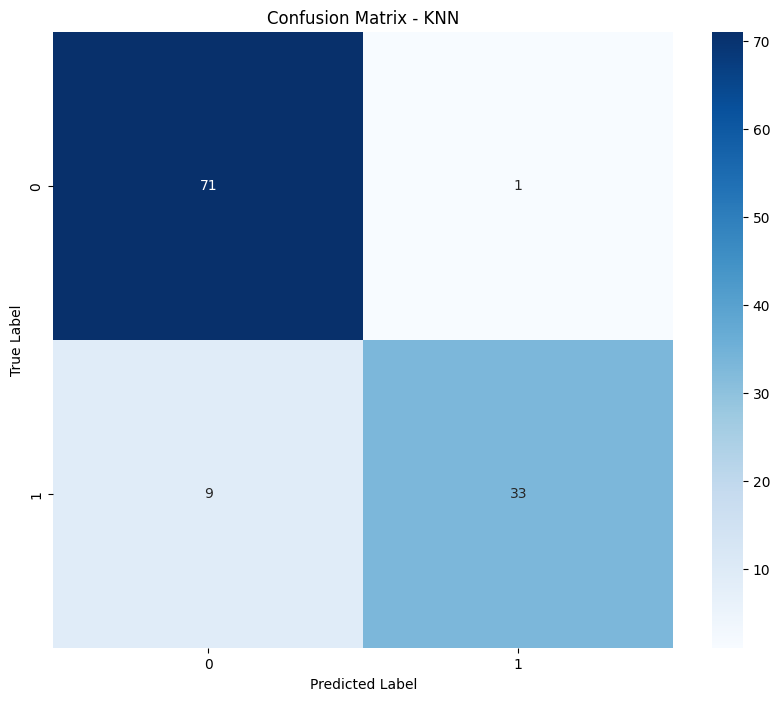

In [28]:
# Import KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Print model performance metrics
print("\nK-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Create confusion matrix
plt.figure(figsize=(10, 8))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - KNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Extra Trees Classifier (ETC), Light Gradient Boosting Machine (LightGBM), Ridge Classifier (RC), and Linear Discriminant Analysis (LDA)

Extra Trees Accuracy: 0.9386
              precision    recall  f1-score   support

   Benign(0)       0.91      1.00      0.95        72
Malignant(1)       1.00      0.83      0.91        42

    accuracy                           0.94       114
   macro avg       0.96      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



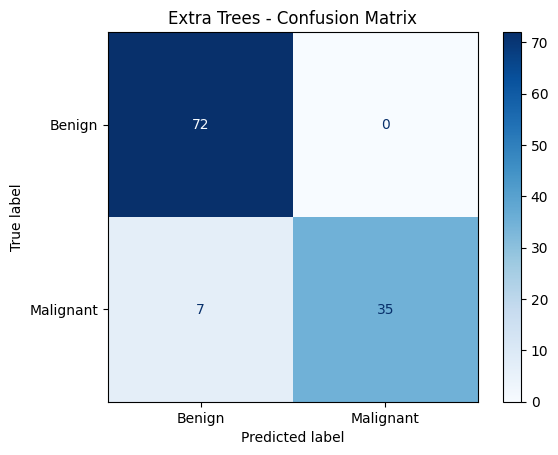

Ridge Classifier Accuracy: 0.9298
              precision    recall  f1-score   support

   Benign(0)       0.90      1.00      0.95        72
Malignant(1)       1.00      0.81      0.89        42

    accuracy                           0.93       114
   macro avg       0.95      0.90      0.92       114
weighted avg       0.94      0.93      0.93       114



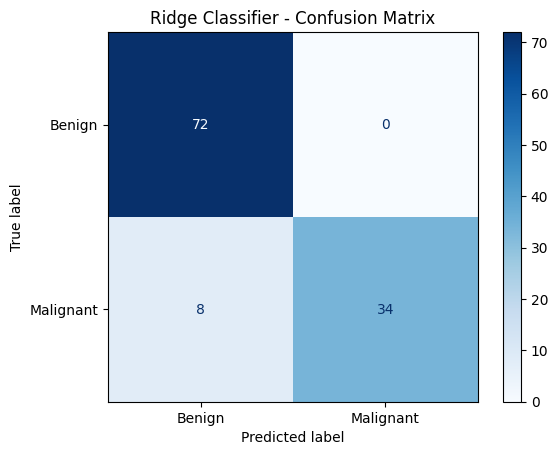

LDA Accuracy: 0.9211
              precision    recall  f1-score   support

   Benign(0)       0.89      1.00      0.94        72
Malignant(1)       1.00      0.79      0.88        42

    accuracy                           0.92       114
   macro avg       0.94      0.89      0.91       114
weighted avg       0.93      0.92      0.92       114



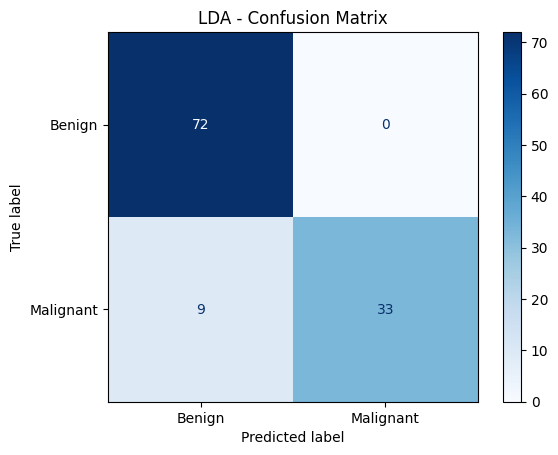

[LightGBM] [Info] Number of positive: 285, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5709
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

d:\ML_ASIF_OWN PROJCET\Breast_Cancer_Classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


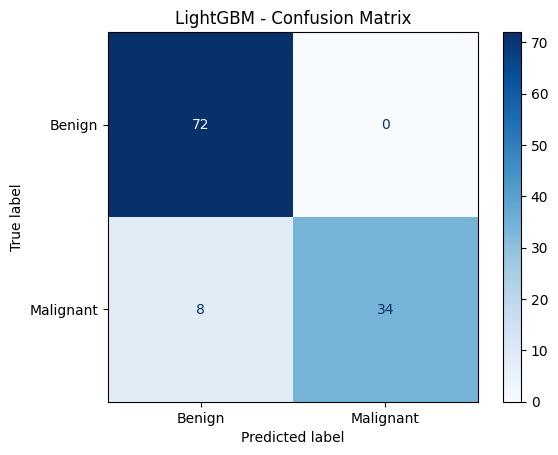

{'Extra Trees': 0.9385964912280702,
 'Ridge Classifier': 0.9298245614035088,
 'LDA': 0.9210526315789473,
 'LightGBM': 0.9298245614035088}

In [29]:
results = {}

etc = ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight='balanced')
rc = RidgeClassifier(random_state=RANDOM_STATE)
lda = LinearDiscriminantAnalysis()

try:
    from lightgbm import LGBMClassifier
    lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    lgbm_available = True
except ImportError:
    lgbm = None
    lgbm_available = False

from sklearn.metrics import ConfusionMatrixDisplay

def evaluate(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    acc = accuracy_score(yte, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')
    print(classification_report(yte, y_pred, target_names=['Benign(0)', 'Malignant(1)']))
    cm = confusion_matrix(yte, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant']).plot(cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    return acc

def evaluate_and_store(name, model, Xtr, ytr, Xte, yte, results_dict):
    print('='*80)
    acc = evaluate(name, model, Xtr, ytr, Xte, yte)
    results_dict[name] = acc

evaluate_and_store('Extra Trees', etc, X_train_bal, y_train_bal, X_test_scaled, y_test, results)
evaluate_and_store('Ridge Classifier', rc, X_train_bal, y_train_bal, X_test_scaled, y_test, results)
evaluate_and_store('LDA', lda, X_train_bal, y_train_bal, X_test_scaled, y_test, results)

if lgbm_available:
    evaluate_and_store('LightGBM', lgbm, X_train_bal, y_train_bal, X_test_scaled, y_test, results)
else:
    print('Skipping LightGBM (not installed).')

results

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    acc = accuracy_score(yte, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')
    print(classification_report(yte, y_pred, target_names=['Benign(0)', 'Malignant(1)']))
    cm = confusion_matrix(yte, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant']).plot(cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    return acc

In [31]:
etc = ExtraTreesClassifier(
    n_estimators=500,
    max_features="sqrt",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgbm = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Ridge doesn't have predict_proba → wrap with calibration to enable soft vote
ridge_base = RidgeClassifier(random_state=RANDOM_STATE)
rc_cal = CalibratedClassifierCV(estimator=ridge_base, method="sigmoid", cv=5)

lda = LinearDiscriminantAnalysis()

voting = VotingClassifier(
    estimators=[("etc", etc), ("lgbm", lgbm), ("rc", rc_cal), ("lda", lda)],
    voting="soft"  # now valid, all members expose predict_proba
)
voting

,estimators,"[('etc', ...), ('lgbm', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


## Train Ensemble

In [32]:
voting.fit(X_train_res_scaled, y_train_res)

[LightGBM] [Info] Number of positive: 285, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5705
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

,estimators,"[('etc', ...), ('lgbm', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


## Evaluate (Accuracy, Report, Confusion Matrix, ROC-AUC)

[LightGBM] [Info] Number of positive: 285, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5709
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

d:\ML_ASIF_OWN PROJCET\Breast_Cancer_Classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


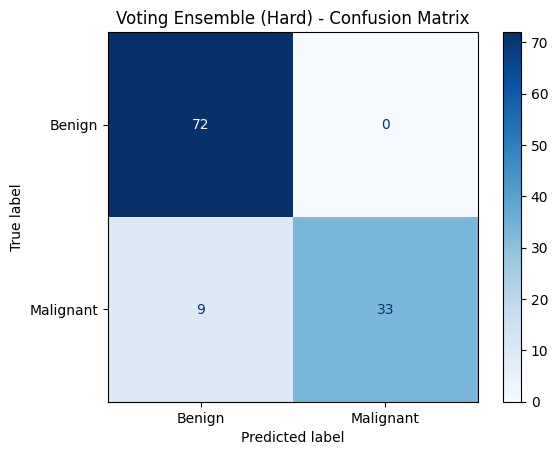


Accuracies:
Extra Trees: 0.9386
Ridge Classifier: 0.9298
LightGBM: 0.9298
LDA: 0.9211
Voting (Hard): 0.9211


In [33]:
# Voting Ensemble (hard voting across the four models)
estimators = [('etc', etc), ('rc', rc), ('lda', lda)]
if lgbm is not None:
    estimators.append(('lgbm', lgbm))

voting = VotingClassifier(estimators=estimators, voting='hard')
print('='*80)
ensemble_acc = evaluate('Voting Ensemble (Hard)', voting, X_train_bal, y_train_bal, X_test_scaled, y_test)

results['Voting (Hard)'] = ensemble_acc

sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print('\nAccuracies:')
for k, v in sorted_results:
    print(f'{k}: {v:.4f}')


## Save Model & Scaler

In [34]:
# Save the best model and the scaler
best_name, best_acc = max(results.items(), key=lambda x: x[1])
print(f'Best model: {best_name} with accuracy {best_acc:.4f}')

# Map names to model constructors for clean refit
constructors = {
    'Extra Trees': lambda: ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight='balanced'),
    'Ridge Classifier': lambda: RidgeClassifier(random_state=RANDOM_STATE),
    'LDA': lambda: LinearDiscriminantAnalysis(),
}
if lgbm is not None:
    constructors['LightGBM'] = lambda: LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
constructors['Voting (Hard)'] = lambda: VotingClassifier(estimators=[
    ('etc', ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight='balanced')),
    ('rc', RidgeClassifier(random_state=RANDOM_STATE)),
    ('lda', LinearDiscriminantAnalysis()),
] + (([('lgbm', LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'))]) if lgbm is not None else []), voting='hard')

best_model = constructors[best_name]()
best_model.fit(X_train_bal, y_train_bal)

joblib.dump(best_model, 'best_model_ensemble.joblib')
joblib.dump(scaler, 'scaler.joblib')
print('Saved best_model_ensemble.joblib and scaler.joblib')


Best model: Extra Trees with accuracy 0.9386
Saved best_model_ensemble.joblib and scaler.joblib
